# Análise de expressão facial com redes neurais

#### MO444 - Aprendizado de Máquina e Reconhecimento de Padrões

______

**Técnica**: Redes neurais.

**Descrição**: Análise da expressão facial utilizando rede neural simples.

**Data**: 14/11/2018

**Bruno Silvério de Freitas** <br>
**Fernanda Ribeiro** <br>
**Fernando Seiti Furusato** <br>
**Gustavo J. Q. Vasconcelos** 
______

# Importando Bibliotecas

In [1]:
%matplotlib inline

# Importar as bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import matplotlib.image as mpimg
import sys
import itertools
import tensorflow as tf
# import cv2

from scipy import signal as sg
from scipy import ndimage as sc
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.layers import Input
from keras.models import model_from_json
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
from keras.utils import np_utils
from keras.optimizers import SGD, Adadelta
from keras import regularizers

# Exibir 10 linhas do conjunto de dados
pd.set_option("max_r",10)
pd.get_option("display.max_rows")

# Estilo do Gráfico
import matplotlib
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive/My Drive/01. Unicamp - Mestrado FT/Disciplinas/201802 - MO444 - Aprendizado de Máquina e Reconhecimento de Padrões/Tarefas/Projeto/Programas/Graficos')

# Métricas

Para esse trabalho avaliaremos a acurácia normalizada (por ser amostras desbalanceadas) e a matriz de confusão.

In [3]:
def accuracy_normalized(y_true,y_pred):
    mc = confusion_matrix(y_true,y_pred)
    mc_margin = np.sum(mc,axis = 1)

    n = len(mc)

    tp = []
    for i in range(n):
        tp.append(mc[i][i]/mc_margin[i])

    accuracy_normalized = np.sum(tp)/n 

    return accuracy_normalized

def acuracia(y_true,y_pred):
    mc = confusion_matrix(y_true,y_pred)
    mc_tot = np.sum(mc)
    n = len(mc)

    tp = []
    for i in range(n):
        tp.append(mc[i][i])

    accuracy = np.sum(tp)/mc_tot 

    return accuracy

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusão',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Observado', fontsize=14)
    plt.xlabel('Predito', fontsize=14)
    plt.tight_layout()

____

## Base de dados

Será utilizado o conjunto de dados `fer2013`, disponível no desafio do [Kaggle](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge).

>The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
<br><br>
 train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. test.csv contains only the "pixels" column and your task is to predict the emotion column.
<br><br>
 The training set consists of 28,709 examples. The public test set used for the leaderboard consists of 3,589 examples. The final test set, which was used to determine the winner of the competition, consists of another 3,589 examples.
<br><br>
 This dataset was prepared by Pierre-Luc Carrier and Aaron Courville, as part of an ongoing research project. They have graciously provided the workshop organizers with a preliminary version of their dataset to use for this contest.


In [4]:
# !pip install -U -q PyDrive

# from google.colab import auth
# auth.authenticate_user()

# from pydrive.drive import GoogleDrive
# from pydrive.auth import GoogleAuth
# from oauth2client.client import GoogleCredentials
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# # https://drive.google.com/file/d/1VjmDEp_VATI3_qk4t3s1lVvqIBNQBr96/view?usp=sharing
# fer2013 = drive.CreateFile({'id': '1VjmDEp_VATI3_qk4t3s1lVvqIBNQBr96'})
# fer2013.GetContentFile('fer2013.csv')
# dados = pd.DataFrame(pd.read_csv('fer2013.csv'))

print(os.getcwd())
DIR = os.getcwd()
dados = pd.DataFrame(pd.read_csv('Dados/fer2013/fer2013.csv'))
dados

/home/ABTLUS/fernando.furusato/mo444a-final


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


### Análise descritiva

Quantidade de amostras para cada expressão facial para as bases de treinamento, validação e teste.

In [5]:
d={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

count = pd.DataFrame(np.c_[dados.emotion.apply(lambda x:d[x]),dados.Usage,np.ones(len(dados))], columns=['emotion','Usage','number'])
count_train = pd.DataFrame(count[count['Usage'] == 'Training'].groupby(['Usage','emotion']).sum())
count_test = pd.DataFrame(count[count['Usage'] == 'PrivateTest'].groupby(['Usage','emotion']).sum())
count_val = pd.DataFrame(count[count['Usage'] == 'PublicTest'].groupby(['Usage','emotion']).sum())

pd.DataFrame(np.c_[count_train.index.levels[1],
                   count_train.values,
                   count_val.values,
                   count_test.values], 
             columns=['Emoção','Treinamento','Validação','Teste'])

,Emoção,Treinamento,Validação,Teste
0,Angry,3995,467,491
1,Disgust,436,56,55
2,Fear,4097,496,528
3,Happy,7215,895,879
4,Neutral,4965,607,626
5,Sad,4830,653,594
6,Surprise,3171,415,416


In [6]:
dados['pixels'] = dados['pixels'].apply(lambda x: np.fromstring(x,sep=' '))

### Dimensão dos dados
Avalia a dimensão do conjunto de dados e dos dados para modelagem

In [7]:
print('===================================')
print('          Dados originais          ')
print('===================================')
print('-----------------------------------')
print('Conjunto de treinamento:')
train = dados.loc[dados['Usage'] == 'Training']
# train = train.sample(500)
train_x = np.vstack(train['pixels'].values)
train_y = pd.get_dummies(train['emotion'])
train_y.columns = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
print('X: {}, y: {}'.format(train_x.shape,train_y.shape))

print('-----------------------------------')
print('Conjunto de validação:')
validation = dados.loc[dados['Usage'] == 'PublicTest']
# validation = validation.sample(300)
validation_x = np.vstack(validation['pixels'].values)
validation_y = pd.get_dummies(validation['emotion'])
validation_y.columns = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
print('X: {}, y: {}'.format(validation_x.shape,validation_y.shape))

print('-----------------------------------')
print('Conjunto de teste:')
test = dados.loc[dados['Usage'] == 'PrivateTest']
# test = test.sample(300)
test_x = np.vstack(test['pixels'].values)
test_y = pd.get_dummies(test['emotion'])
test_y.columns = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
print('X: {}, y: {}'.format(test_x.shape,test_y.shape))
print('-----------------------------------')
print('===================================')

print('\n')
print('===================================')
print('       Dados para modelagem        ')
print('===================================')
print('-----------------------------------')
print('Conjunto de treinamento:')
train_x_conv = np.reshape(train_x,(-1, 1, 48, 48))
print('X: {}'.format(train_x_conv.shape))
print('-----------------------------------')
print('Conjunto de validação:')
validation_x_conv = np.reshape(validation_x,(-1, 1, 48, 48))
print('X: {}'.format(validation_x_conv.shape))
print('-----------------------------------')
print('Conjunto de teste:')
test_x_conv = np.reshape(test_x,(-1, 1, 48, 48))
print('X: {}'.format(test_x_conv.shape))
print('-----------------------------------')
print('===================================')


          Dados originais          
-----------------------------------
Conjunto de treinamento:
X: (28709, 2304), y: (28709, 7)
-----------------------------------
Conjunto de validação:
X: (3589, 2304), y: (3589, 7)
-----------------------------------
Conjunto de teste:
X: (3589, 2304), y: (3589, 7)
-----------------------------------


       Dados para modelagem        
-----------------------------------
Conjunto de treinamento:
X: (28709, 1, 48, 48)
-----------------------------------
Conjunto de validação:
X: (3589, 1, 48, 48)
-----------------------------------
Conjunto de teste:
X: (3589, 1, 48, 48)
-----------------------------------


#### Exemplo do conjunto de dados de treinamento

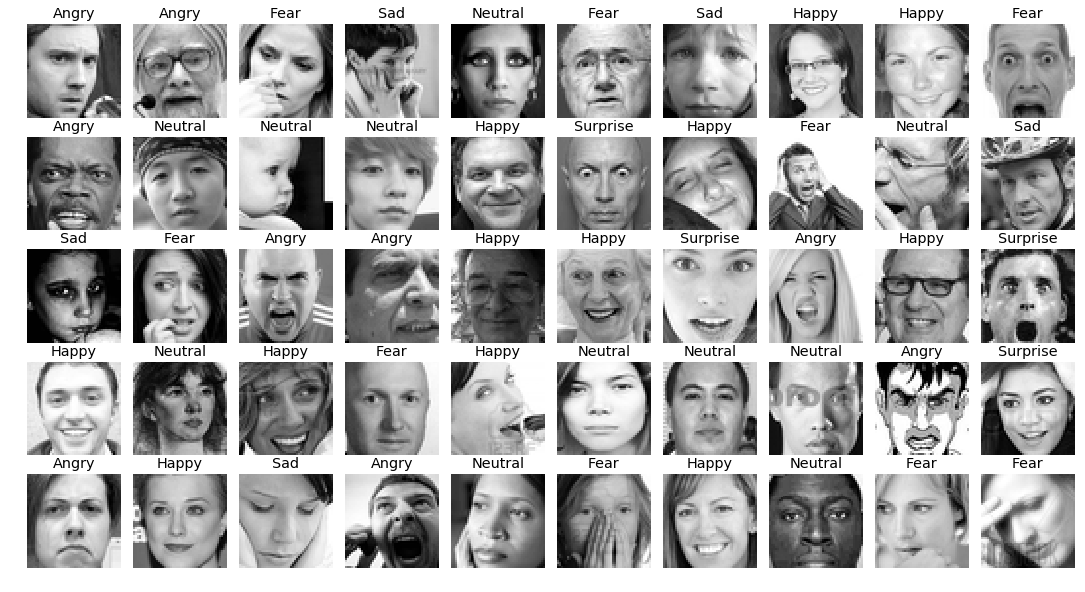

In [8]:
fig, axs = plt.subplots(5,10, figsize=(19, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.0001)
axs = axs.ravel()

for i in range(50):
    axs[i].imshow(train_x_conv.squeeze()[i], cmap='gray')
    axs[i].set_title(train_y.loc[i,train_y.loc[i]==1].index[0])
    axs[i].axis('off')

### Padronização do conjunto de dados

In [9]:
train_x_conv = train_x_conv.astype('float32') / 255
test_x_conv = test_x_conv.astype('float32') / 255
validation_x_conv  = validation_x_conv.astype('float32') / 255

In [10]:
num_classes = train_y.shape[1]
print(num_classes)

input_shape = (1, 48, 48)

7


_____
## Rede Neural Convolucional

Abaixo será implementada uma rede neural convolucional simples, a fim de avaliar previamente o desempenho no conjunto de dados e, posteriormente, outros modelos serão aplicados. Para abrir o ``Tensorboard``:

In [11]:
def CNN_Simples(input_shape):
    
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=input_shape, data_format="channels_first"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))  
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax')) #Probabilidade de cada classe
    
    
    return model    

Camadas do modelo:

In [12]:
model = CNN_Simples(input_shape)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 44, 44)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 44, 44)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 22, 44)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 20, 64)        25408     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 20, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 20, 64)        0  

### Compilando o modelo

In [13]:
# https://www.davidtvs.com/keras-custom-metrics/

class AccNorm(object):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def acc_norm(self, y_true, y_pred):
        # Wraps np_mean_iou method and uses it as a TensorFlow op.
        # Takes numpy arrays as its arguments and returns numpy arrays as
        # its outputs.
        
        return tf.py_func(self.np_acc_norm, [y_true, y_pred], tf.float32)        

    
    def np_acc_norm(self, y_true, y_pred):
        # Compute the confusion matrix to get the number of true positives,
        # false positives, and false negatives
        # Convert predictions and target from categorical to integer format
        target = np.argmax(y_true, axis=-1).ravel()
        predicted = np.argmax(y_pred, axis=-1).ravel()

        # Trick from torchnet for bincounting 2 arrays together
        # https://github.com/pytorch/tnt/blob/master/torchnet/meter/confusionmeter.py
        x = predicted + self.num_classes * target
        bincount_2d = np.bincount(x.astype(np.int32), minlength=self.num_classes**2)
        assert bincount_2d.size == self.num_classes**2
        conf = bincount_2d.reshape((self.num_classes, self.num_classes))

        # Compute the IoU and mean IoU from the confusion matrix
        true_positive = np.diag(conf)
        total = np.sum(conf, 1)
        false_positive = np.sum(conf, 0) - true_positive
        false_negative = np.sum(conf, 1) - true_positive

        # Just in case we get a division by 0, ignore/hide the error and set the value to 0
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / total #(true_positive + false_positive + false_negative)
        iou[np.isnan(iou)] = 0
#         print('conf: \n', conf, '\n true_positive: \n', true_positive, '\n total: \n', total, '\n iou: \n',iou)
#         print('acc: ',np.mean(iou).astype(np.float32))
        return np.mean(iou).astype(np.float32)

num_classes = len(np.unique(train['emotion']))
acc_metric = AccNorm(num_classes)

In [14]:
# https://github.com/keras-team/keras/issues/10426
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy",acc_metric.acc_norm])

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [15]:
num_epoch = 500
num_batch = 1024

checkpointer   = ModelCheckpoint(filepath=os.path.join('./Modelos/cnn_simples_emocoes_weights.h5'), verbose=1, save_best_only=True, monitor='val_acc_norm')
csv_logger     = CSVLogger(os.path.join('./Modelos/cnn_simples_training.log'))
early_stopping = EarlyStopping(monitor='val_acc_norm', min_delta=0, patience=5, verbose=1, mode='max')
tensorboard = TensorBoard('./TensorBoard/CNN Simples',  write_graph=True, write_images=False)

model_history = model.fit(train_x_conv, train_y, epochs=num_epoch, batch_size=num_batch, shuffle=True, validation_data=(validation_x_conv, validation_y), verbose=1, callbacks=[tensorboard, early_stopping, checkpointer, csv_logger])

Instructions for updating:
Use tf.cast instead.
Train on 28709 samples, validate on 3589 samples
Epoch 1/500
28709/28709 [==============================] - 24s 849us/step - loss: 1.8299 - acc: 0.2387 - acc_norm: 0.1430 - val_loss: 1.8002 - val_acc: 0.2494 - val_acc_norm: 0.1429

Epoch 00001: val_acc_norm improved from -inf to 0.14286, saving model to ./Modelos/cnn_simples_emocoes_weights.h5
Epoch 2/500
28709/28709 [==============================] - 24s 826us/step - loss: 1.7910 - acc: 0.2563 - acc_norm: 0.1572 - val_loss: 1.7961 - val_acc: 0.2491 - val_acc_norm: 0.1430

Epoch 00002: val_acc_norm improved from 0.14286 to 0.14296, saving model to ./Modelos/cnn_simples_emocoes_weights.h5
Epoch 3/500
28709/28709 [==============================] - 24s 831us/step - loss: 1.7631 - acc: 0.2753 - acc_norm: 0.1942 - val_loss: 1.7186 - val_acc: 0.3143 - val_acc_norm: 0.2513

Epoch 00003: val_acc_norm improved from 0.14296 to 0.25133, saving model to ./Modelos/cnn_simples_emocoes_weights.h5
Epoch 


Epoch 00029: val_acc_norm did not improve from 0.42043
Epoch 30/500
28709/28709 [==============================] - 13s 449us/step - loss: 0.9871 - acc: 0.6315 - acc_norm: 0.5411 - val_loss: 1.4545 - val_acc: 0.4603 - val_acc_norm: 0.4137

Epoch 00030: val_acc_norm did not improve from 0.42043
Epoch 31/500
28709/28709 [==============================] - 13s 445us/step - loss: 0.9854 - acc: 0.6328 - acc_norm: 0.5492 - val_loss: 1.3993 - val_acc: 0.4904 - val_acc_norm: 0.4199

Epoch 00031: val_acc_norm did not improve from 0.42043
Epoch 32/500
28709/28709 [==============================] - 13s 446us/step - loss: 0.9473 - acc: 0.6475 - acc_norm: 0.5666 - val_loss: 1.3787 - val_acc: 0.5010 - val_acc_norm: 0.4335

Epoch 00032: val_acc_norm improved from 0.42043 to 0.43354, saving model to ./Modelos/cnn_simples_emocoes_weights.h5
Epoch 33/500
28709/28709 [==============================] - 13s 448us/step - loss: 0.9223 - acc: 0.6555 - acc_norm: 0.5766 - val_loss: 1.4204 - val_acc: 0.4962 - val

28709/28709 [==============================] - 13s 449us/step - loss: 0.4420 - acc: 0.8402 - acc_norm: 0.8135 - val_loss: 1.7827 - val_acc: 0.5099 - val_acc_norm: 0.4703

Epoch 00061: val_acc_norm did not improve from 0.48732
Epoch 00061: early stopping


In [16]:
# Probabilidades de cada classe
predito = model.predict_classes(train_x_conv)
predito_new = model.predict_classes(validation_x_conv)

obs = train['emotion']
obs_new = validation['emotion']

classes = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

### Calcula a matriz de confusão:

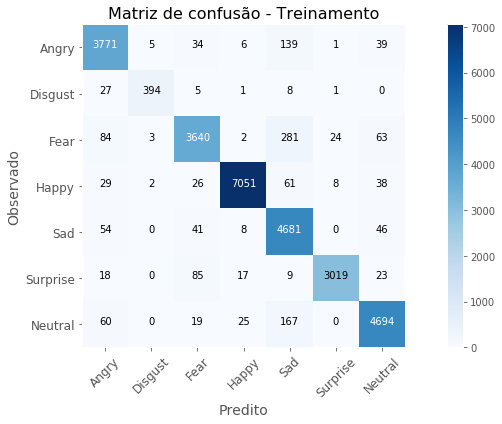

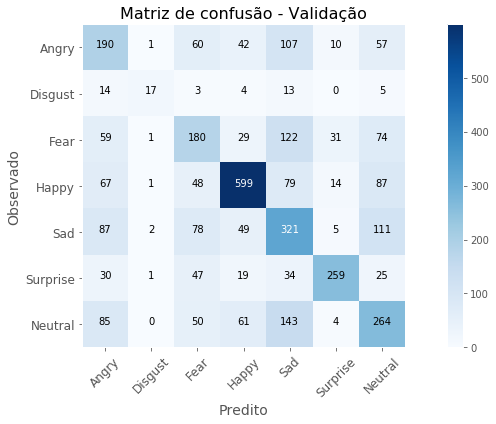

In [17]:
fig1, axes1 = plt.subplots(nrows=1, ncols=1,figsize=(12,6))
graf_confusion_new = plot_confusion_matrix(confusion_matrix(obs,predito), normalize = False, classes=classes,title="Matriz de confusão - Treinamento")
axes1.grid(b=False)

fig2, axes2 = plt.subplots(nrows=1, ncols=1,figsize=(12,6))
graf_confusion_new = plot_confusion_matrix(confusion_matrix(obs_new,predito_new), normalize = False, classes=classes,title="Matriz de confusão - Validação")
axes2.grid(b=False)

### Gráfico das métricas em cada epoch

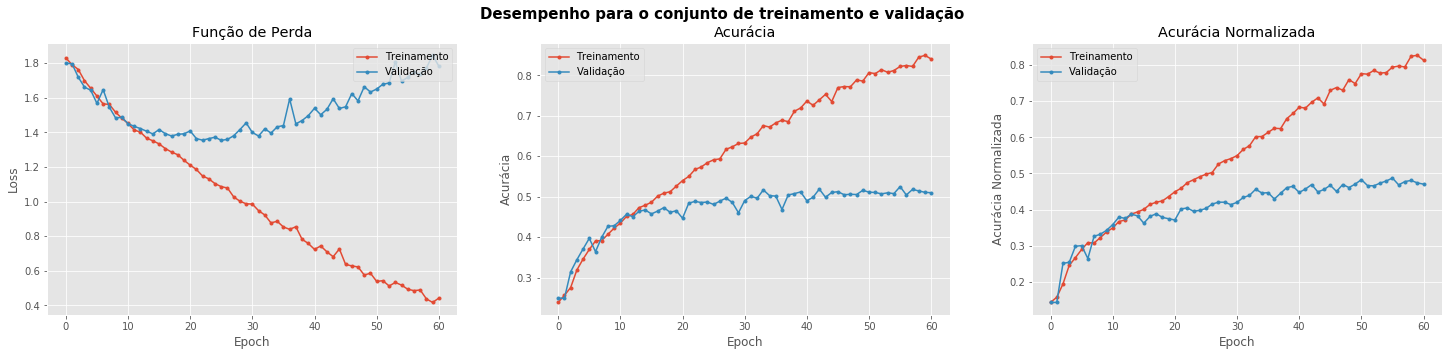

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,5))
plt.suptitle('Desempenho para o conjunto de treinamento e validação', fontsize=15, fontweight='bold')
axes[0].plot(model_history.history['loss'],marker='.')
axes[0].plot(model_history.history['val_loss'],marker='.')
axes[0].set_title('Função de Perda')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Treinamento', 'Validação'], loc='upper right')

axes[1].plot(model_history.history['acc'],marker='.')
axes[1].plot(model_history.history['val_acc'],marker='.')
axes[1].set_title('Acurácia')
axes[1].set_ylabel('Acurácia')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Treinamento', 'Validação'], loc='upper left')

axes[2].plot(model_history.history['acc_norm'],marker='.')
axes[2].plot(model_history.history['val_acc_norm'],marker='.')
axes[2].set_title('Acurácia Normalizada')
axes[2].set_ylabel('Acurácia Normalizada')
axes[2].set_xlabel('Epoch')
axes[2].legend(['Treinamento', 'Validação'], loc='upper left')

------
## Aplicando o melhor modelo nos conjuntos de dados

In [19]:
from keras.models import load_model

# returns a compiled model identical to the previous one
model = load_model('./Modelos/cnn_simples_emocoes_weights.h5', custom_objects={'acc_norm': acc_metric.acc_norm})

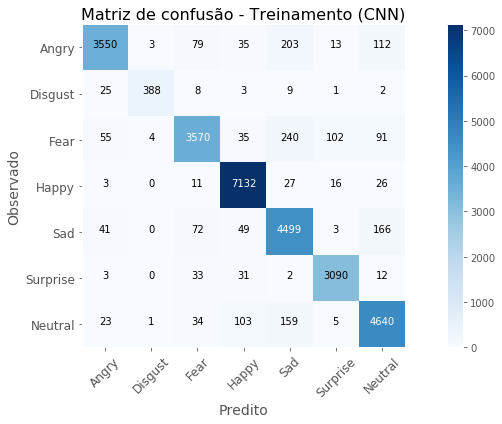

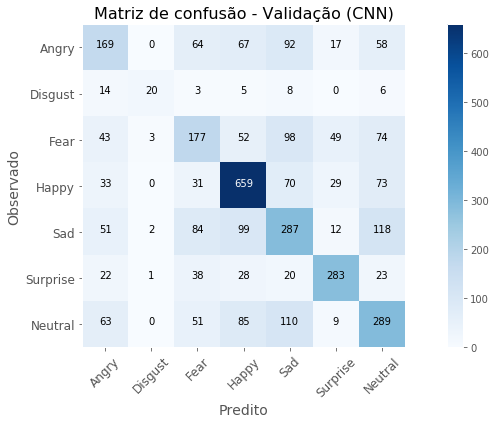

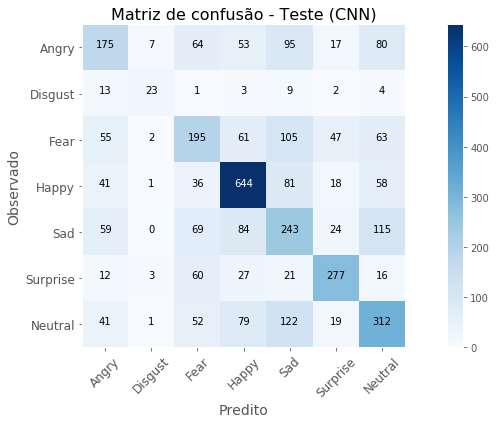

In [20]:
# Probabilidades de cada classe
predito = model.predict_classes(train_x_conv)
predito_new = model.predict_classes(validation_x_conv)
predito_new_tst = model.predict_classes(test_x_conv)

obs = train['emotion']
obs_new = validation['emotion']
obs_new_tst = test['emotion']

classes = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

fig1, axes1 = plt.subplots(nrows=1, ncols=1,figsize=(12,6))
graf_confusion_new = plot_confusion_matrix(confusion_matrix(obs,predito), normalize = False, classes=classes,title="Matriz de confusão - Treinamento (CNN)")
axes1.grid(b=False)

fig2, axes2 = plt.subplots(nrows=1, ncols=1,figsize=(12,6))
graf_confusion_new = plot_confusion_matrix(confusion_matrix(obs_new,predito_new), normalize = False, classes=classes,title="Matriz de confusão - Validação (CNN)")
axes2.grid(b=False)

fig3, axes3 = plt.subplots(nrows=1, ncols=1,figsize=(12,6))
graf_confusion_new = plot_confusion_matrix(confusion_matrix(obs_new_tst,predito_new_tst), normalize = False, classes=classes,title="Matriz de confusão - Teste (CNN)")
axes3.grid(b=False)